# Where to Start a User-Specified Restaurant/Cafe Business in Manhattan 

## Summary:
<ol>
<li>Get the neighboroods in NYC and focus on Manhattan </li>
<li>Get the hot spots in Manhattan neighborhoods</li>
<li>Get user input on what type of retaurant/cafe he/she is willing to start</li>
<li>Search for the venues that match the user entry in Manhattan Neighborhoods</li>
<li>Get the number of matched venues in each neighborhood as well as their rating and price</li>
<li>Cluster neighborhoods according to the number of venues that match the user cuisne of interest, avg rating,avg price and surrounding hot spots</li>
<li>Examine the clusters to know where to start the business </li>

### Import required libraries

In [1]:
import pandas as pd 
import geocoder # to get latitude and longitude values
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import datasets
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



## Get the newyork dataset that contains the neighborhoods, boroughs, lat and long

In [2]:
!wget https://cocl.us/new_york_dataset

--2020-11-11 15:24:05--  https://cocl.us/new_york_dataset
Resolving cocl.us (cocl.us)... 169.63.96.176, 169.63.96.194
Connecting to cocl.us (cocl.us)|169.63.96.176|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DP0701EN/data/nyu_2451_34572-geojson.json [following]
--2020-11-11 15:24:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DP0701EN/data/nyu_2451_34572-geojson.json
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115774 (113K) [application/octet-stream]
Saving to: 'new_york_dataset.16'

     0K .......... .......... .......... .......... .......... 44% 44.3K 1s
    50K 

Load the data

In [3]:
with open('new_york_dataset') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Get only relevant data which is in the features key

In [5]:
NY_data = newyork_data['features']
NY_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## Convert JSON to Dataframe

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neigh = pd.DataFrame(columns=column_names)

In [7]:
for data in NY_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neigh = NY_neigh.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
NY_neigh

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631


### Show NYC Neighborhoods on Map 

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NY_neigh['Borough'].unique()),
        NY_neigh.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NY_neigh['Latitude'], NY_neigh['Longitude'], NY_neigh['Borough'], NY_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_newyork)  
    
map_newyork


### Focus on Manhattan Borough only 

In [12]:
manhattan_dataset = NY_neigh[NY_neigh['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_dataset

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


Show Manhattan Neighborhoods on map

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudee = location.latitude
longitudee = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitudee, longitudee))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitudee, longitudee], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_dataset['Latitude'], manhattan_dataset['Longitude'], manhattan_dataset['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Connect to Forsquare API

In [15]:
# @hidden_cell

CLIENT_ID = 'PTYI3W1TEN4UXF242ICMVB11MLF5UILKMEDH0WJL5VAIABZW' # your Foursquare ID
CLIENT_SECRET = 'PGGXVZO0A5HTPIAV1MWO0BP4TKY4WLAX5PMPDA1JL4CXL1YC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials Known')

Credentials Known


### Get the Venues in each Neighborhood in Manhattan

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Nearby Venue Name', 
                  'Nearby Venue ID',    
                  'Nearby Venue Latitude', 
                  'Nearby Venue Longitude', 
                  'Nearby Venue Category']
    
    return(nearby_venues)

In [17]:
LIMIT=100
manhattan_venues = getNearbyVenues(names=manhattan_dataset['Neighborhood'],
                                   latitudes=manhattan_dataset['Latitude'],
                                   longitudes=manhattan_dataset['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Show the venues dataframe

In [18]:
manhattan_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Nearby Venue Name,Nearby Venue ID,Nearby Venue Latitude,Nearby Venue Longitude,Nearby Venue Category
0,Marble Hill,40.876551,-73.910660,Arturo's,4b4429abf964a52037f225e3,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.910660,Bikram Yoga,4baf59e8f964a520a6f93be3,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.910660,Tibbett Diner,4b79cc46f964a520c5122fe3,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.910660,Dunkin',4b5357adf964a520319827e3,40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.910660,Starbucks,55f81cd2498ee903149fcc64,40.877531,-73.905582,Coffee Shop
...,...,...,...,...,...,...,...,...
3199,Hudson Yards,40.756658,-74.000111,StarDust,512ff93be4b0ef4effd7560b,40.759869,-73.996460,Nightclub
3200,Hudson Yards,40.756658,-74.000111,Big George's Smokehouse,59da6a2c0a08ab3b81d58d8d,40.757954,-74.002296,BBQ Joint
3201,Hudson Yards,40.756658,-74.000111,NY Waterway 42nd St Bus,4d8bee412505a35df076a352,40.760050,-74.003379,Bus Station
3202,Hudson Yards,40.756658,-74.000111,Twilight Cruise By Citysightseeing,4e3dce6f1f6e844231eb1f23,40.759744,-74.004096,Boat or Ferry


### Get the all venue categories in the Forsquare API and put it in a dataframe 
There are 4 levels of categories (basic level is the primary level)

In [19]:
url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
results = requests.get(url).json()["response"]['categories']
totalprimarycat=len(results)
pcat_list=list()
scat_list=list()
tcat_list=list()
fcat_list=list()
for pc in range(totalprimarycat):
    res= results[pc]['categories']
    seconadrycat=len(res)
    for sc in range(seconadrycat):
        res1= res[sc]['categories']
        thirdcat=len(res1)
        if(thirdcat==0):
            pcat_list.append(results[pc]['name'])
            scat_list.append(res[sc]['name'])
            tcat_list.append('---')
            fcat_list.append('---')
            continue
        
        for tc in range(thirdcat):
            res2= res1[tc]['categories']
            fourthcat=len(res2)
            if(fourthcat==0):
                pcat_list.append(results[pc]['name'])
                scat_list.append(res[sc]['name'])
                tcat_list.append(res1[tc]['name'])
                fcat_list.append('---')
                continue
            for fc in range(fourthcat):
                pcat_list.append(results[pc]['name'])
                scat_list.append(res[sc]['name'])
                tcat_list.append(res1[tc]['name'])
                fcat_list.append(res2[fc]['name'])
                
dic={'Primary_Category':pcat_list, 'Secondary_Category':scat_list, 'Third_Category':tcat_list,'Fourth_Category':fcat_list}   
cat_df=pd.DataFrame(dic)

Compare the venues dataframe with the categories dataframe and get the venues primary category
(The primary category will be used later for clustering)

In [20]:
manhattan_venues['Nearby_Venue_Primary_Category']='A'
for index, row in manhattan_venues.iterrows():
    value=row['Nearby Venue Category']
    prcat=cat_df.isin({'Primary_Category':[value]}).any().any()
    sccat=cat_df.isin({'Secondary_Category':[value]}).any().any()
    thcat=cat_df.isin({'Third_Category':[value]}).any().any()
    focat=cat_df.isin({'Fourth_Category':[value]}).any().any()
    if (prcat or sccat or thcat or focat):
        if (prcat):
            p=cat_df.loc[cat_df['Primary_Category'] == value, 'Primary_Category'].iloc[0]
        elif (sccat):
            p=cat_df.loc[cat_df['Secondary_Category'] == value, 'Primary_Category'].iloc[0]
        elif (thcat):
            p=cat_df.loc[cat_df['Third_Category'] == value, 'Primary_Category'].iloc[0]
        elif (focat):
            p=cat_df.loc[cat_df['Fourth_Category'] == value, 'Primary_Category'].iloc[0]
        manhattan_venues.at[index,'Nearby_Venue_Primary_Category']=p
manhattan_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Nearby Venue Name,Nearby Venue ID,Nearby Venue Latitude,Nearby Venue Longitude,Nearby Venue Category,Nearby_Venue_Primary_Category
0,Marble Hill,40.876551,-73.910660,Arturo's,4b4429abf964a52037f225e3,40.874412,-73.910271,Pizza Place,Food
1,Marble Hill,40.876551,-73.910660,Bikram Yoga,4baf59e8f964a520a6f93be3,40.876844,-73.906204,Yoga Studio,Outdoors & Recreation
2,Marble Hill,40.876551,-73.910660,Tibbett Diner,4b79cc46f964a520c5122fe3,40.880404,-73.908937,Diner,Food
3,Marble Hill,40.876551,-73.910660,Dunkin',4b5357adf964a520319827e3,40.877136,-73.906666,Donut Shop,Food
4,Marble Hill,40.876551,-73.910660,Starbucks,55f81cd2498ee903149fcc64,40.877531,-73.905582,Coffee Shop,Food
...,...,...,...,...,...,...,...,...,...
3199,Hudson Yards,40.756658,-74.000111,StarDust,512ff93be4b0ef4effd7560b,40.759869,-73.996460,Nightclub,Nightlife Spot
3200,Hudson Yards,40.756658,-74.000111,Big George's Smokehouse,59da6a2c0a08ab3b81d58d8d,40.757954,-74.002296,BBQ Joint,Food
3201,Hudson Yards,40.756658,-74.000111,NY Waterway 42nd St Bus,4d8bee412505a35df076a352,40.760050,-74.003379,Bus Station,Travel & Transport
3202,Hudson Yards,40.756658,-74.000111,Twilight Cruise By Citysightseeing,4e3dce6f1f6e844231eb1f23,40.759744,-74.004096,Boat or Ferry,Travel & Transport


Remove the Food category as it is irrelevant. 
We only want non-food hot spots that are around the venues which are similar to the user's selected cuisine type

In [21]:
manhattan_venues=manhattan_venues[manhattan_venues['Nearby_Venue_Primary_Category']!='Food']

In [22]:
manhattan_venues=manhattan_venues.drop_duplicates(subset=['Neighborhood','Nearby_Venue_Primary_Category'])
manhattan_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Nearby Venue Name,Nearby Venue ID,Nearby Venue Latitude,Nearby Venue Longitude,Nearby Venue Category,Nearby_Venue_Primary_Category
1,Marble Hill,40.876551,-73.910660,Bikram Yoga,4baf59e8f964a520a6f93be3,40.876844,-73.906204,Yoga Studio,Outdoors & Recreation
7,Marble Hill,40.876551,-73.910660,Rite Aid,4b88e053f964a5208a1132e3,40.875467,-73.908906,Pharmacy,Shop & Service
9,Marble Hill,40.876551,-73.910660,TCR The Club of Riverdale,4a725fa1f964a520f6da1fe3,40.878628,-73.914568,Tennis Stadium,Arts & Entertainment
23,Chinatown,40.715618,-73.994279,Hotel 50 Bowery,578692f4498e1054905dbde7,40.715936,-73.996789,Hotel,Travel & Transport
25,Chinatown,40.715618,-73.994279,Bar Belly,503fffabe4b05e5c0eace385,40.715135,-73.991802,Cocktail Bar,Nightlife Spot
...,...,...,...,...,...,...,...,...,...
3146,Hudson Yards,40.756658,-74.000111,Brooklyn Fare,514ca6f57043482a0c84e7ab,40.756130,-73.996614,Supermarket,Shop & Service
3147,Hudson Yards,40.756658,-74.000111,DiMenna Center for Classical Music,4daf05e343a1f97d91988078,40.756323,-73.997192,Music School,Professional & Other Places
3148,Hudson Yards,40.756658,-74.000111,505W37,4b6c43bdf964a5208f2c2ce3,40.756909,-73.998007,Residential Building (Apartment / Condo),Residence
3150,Hudson Yards,40.756658,-74.000111,Equinox Hotel - Hudson Yards,5c9aaee431ac6c0039a49499,40.754768,-74.001986,Hotel,Travel & Transport


Group by neighborhood and only keep the required categories 
(categories for each neigborhood is concatenated and seperated by a ',')

In [23]:
manhattan_venues_grouped=manhattan_venues.groupby(['Neighborhood'])['Nearby_Venue_Primary_Category'].apply(lambda x: ','.join(x)).reset_index()

In [24]:
for index, row in manhattan_venues_grouped.iterrows():
    l=row["Nearby_Venue_Primary_Category"].split(',')
    l.sort()
    listToStr = ','.join([str(elem) for elem in l]) 
    manhattan_venues_grouped.at[index,'Nearby_Venue_Primary_Category']=listToStr

manhattan_venues_grouped

,Neighborhood,Nearby_Venue_Primary_Category
0,Battery Park City,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
1,Carnegie Hill,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
2,Central Harlem,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
3,Chelsea,"Arts & Entertainment,College & University,Nigh..."
4,Chinatown,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
5,Civic Center,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
6,Clinton,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
7,East Harlem,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
8,East Village,"Arts & Entertainment,Nightlife Spot,Outdoors &..."
9,Financial District,"Arts & Entertainment,Nightlife Spot,Outdoors &..."


### Get the user's input in terms of what cuisine he/she is interested in

let's take the example of Italian Cuisine

In [25]:
user=input('Enter your cuisine/cafe of interest: ')

Enter your cuisine/cafe of interest: Italian


### Search for venues that match the user's cuisine of interest
In the example of Italian cuisine...this will get all Italian related venues in the Neigborhoods in Manhattan
This will later will be used to count the number of the venues that match the user's entry in a Neighborhood and this in return will help with clustering

In [26]:
def searchvenue(names, latitudes, longitudes,search_query,radius=500):
    trending_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()['response']['venues'] 
        if(len(results)!=0):
            l=[]
            for v in results:
                if (v['categories']==[]):
                    cat='---'
                else:
                    cat=v['categories'][0]['name']
                l.append((
                        name,
                        lat, 
                        lng, 
                        v['name'],
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],  
                        cat))
            trending_list.append(l)

    search = pd.DataFrame([item for trending_list in trending_list for item in trending_list])
    search.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue_Name', 
                  'Venue_ID',
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
   
    return(search)

In [27]:
LIMIT=100
manhattan_search = searchvenue(names=manhattan_dataset['Neighborhood'],
                                   latitudes=manhattan_dataset['Latitude'],
                                   longitudes=manhattan_dataset['Longitude'],
                                   search_query=user
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Show the search dataframe...............
so in the example of italian, this dataframe will show all exisitng italian related venues in all neighborhoods in Manhattan

In [28]:
manhattan_search

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category
0,Chinatown,40.715618,-73.994279,Italian American Museum Of New York,4b9d4c67f964a5206ca136e3,40.719191,-73.997376,History Museum
1,Chinatown,40.715618,-73.994279,Italian Food Center,51a63ef7498e9eedb94e0c5f,40.719589,-73.997339,Italian Restaurant
2,Chinatown,40.715618,-73.994279,Bones & Jones Italian Beef,53823e43498e17831b23b7aa,40.715538,-73.989596,Food Truck
3,Chinatown,40.715618,-73.994279,Little Italian Rooftop,4d97923e61a3a1cdb92ab942,40.718063,-73.998161,Scenic Lookout
4,Chinatown,40.715618,-73.994279,Grand Tuscany Ristorante Italiano,4e4c3b37bd413c4cc667d4a8,40.719269,-73.997765,Italian Restaurant
...,...,...,...,...,...,...,...,...
171,Flatiron,40.739673,-73.990947,Old Fashioned Hand Made Italian Ice,5014183ce4b0073bd04161fa,40.743568,-73.991700,Food Truck
172,Flatiron,40.739673,-73.990947,Cesar NYC Kitchens,574c24f9498e3a7d0efcd58c,40.742260,-73.991692,Furniture / Home Store
173,Hudson Yards,40.756658,-74.000111,Catria Modern Italian,5e53415c3e613c0008e067d8,40.754677,-73.998657,Italian Restaurant
174,Hudson Yards,40.756658,-74.000111,Villa Fresh Italian Kitchen,4e18ce19483b5cfa49cec3b6,40.758566,-73.999109,Pizza Place


Check the unique categories 

In [29]:
manhattan_search["Venue_Category"].unique()

array(['History Museum', 'Italian Restaurant', 'Food Truck',
       'Scenic Lookout', 'Ice Cream Shop', 'School', 'Food',
       'Embassy / Consulate', 'Non-Profit', 'Language School',
       'Pizza Place', 'Theater', 'Deli / Bodega',
       'General College & University', 'Public Art', 'Clothing Store',
       'Office', 'Café', 'Sandwich Place', 'Bakery', '---', 'Shoe Store',
       'College Arts Building', 'Cocktail Bar', 'Art Gallery',
       'Dessert Shop', 'High School', 'Gourmet Shop',
       'College Academic Building', 'College Classroom', 'Cooking School',
       'Wine Shop', 'Furniture / Home Store'], dtype=object)

So we are only interested in Food related venues in this case so that we count how many food venues are related to the user cuisine of interest.....
Below we get the primary categories for each venue then we will only keep food related categories

In [30]:
manhattan_search['Primary_Venue_Category']='A'
for index, row in manhattan_search.iterrows():
    value=row['Venue_Category']
    prcat=cat_df.isin({'Primary_Category':[value]}).any().any()
    sccat=cat_df.isin({'Secondary_Category':[value]}).any().any()
    thcat=cat_df.isin({'Third_Category':[value]}).any().any()
    focat=cat_df.isin({'Fourth_Category':[value]}).any().any()
    if (prcat or sccat or thcat or focat):
        if (prcat):
            p=cat_df.loc[cat_df['Primary_Category'] == value, 'Primary_Category'].iloc[0]
        elif (sccat):
            p=cat_df.loc[cat_df['Secondary_Category'] == value, 'Primary_Category'].iloc[0]
        elif (thcat):
            p=cat_df.loc[cat_df['Third_Category'] == value, 'Primary_Category'].iloc[0]
        elif (focat):
            p=cat_df.loc[cat_df['Fourth_Category'] == value, 'Primary_Category'].iloc[0]
        manhattan_search.at[index,'Primary_Venue_Category']=p
manhattan_search

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category,Primary_Venue_Category
0,Chinatown,40.715618,-73.994279,Italian American Museum Of New York,4b9d4c67f964a5206ca136e3,40.719191,-73.997376,History Museum,Arts & Entertainment
1,Chinatown,40.715618,-73.994279,Italian Food Center,51a63ef7498e9eedb94e0c5f,40.719589,-73.997339,Italian Restaurant,Food
2,Chinatown,40.715618,-73.994279,Bones & Jones Italian Beef,53823e43498e17831b23b7aa,40.715538,-73.989596,Food Truck,Food
3,Chinatown,40.715618,-73.994279,Little Italian Rooftop,4d97923e61a3a1cdb92ab942,40.718063,-73.998161,Scenic Lookout,Outdoors & Recreation
4,Chinatown,40.715618,-73.994279,Grand Tuscany Ristorante Italiano,4e4c3b37bd413c4cc667d4a8,40.719269,-73.997765,Italian Restaurant,Food
...,...,...,...,...,...,...,...,...,...
171,Flatiron,40.739673,-73.990947,Old Fashioned Hand Made Italian Ice,5014183ce4b0073bd04161fa,40.743568,-73.991700,Food Truck,Food
172,Flatiron,40.739673,-73.990947,Cesar NYC Kitchens,574c24f9498e3a7d0efcd58c,40.742260,-73.991692,Furniture / Home Store,Shop & Service
173,Hudson Yards,40.756658,-74.000111,Catria Modern Italian,5e53415c3e613c0008e067d8,40.754677,-73.998657,Italian Restaurant,Food
174,Hudson Yards,40.756658,-74.000111,Villa Fresh Italian Kitchen,4e18ce19483b5cfa49cec3b6,40.758566,-73.999109,Pizza Place,Food


Keep Food related Categories only

In [31]:
manhattan_search=manhattan_search[manhattan_search['Primary_Venue_Category']=='Food']
manhattan_search

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Name,Venue_ID,Venue_Latitude,Venue_Longitude,Venue_Category,Primary_Venue_Category
1,Chinatown,40.715618,-73.994279,Italian Food Center,51a63ef7498e9eedb94e0c5f,40.719589,-73.997339,Italian Restaurant,Food
2,Chinatown,40.715618,-73.994279,Bones & Jones Italian Beef,53823e43498e17831b23b7aa,40.715538,-73.989596,Food Truck,Food
4,Chinatown,40.715618,-73.994279,Grand Tuscany Ristorante Italiano,4e4c3b37bd413c4cc667d4a8,40.719269,-73.997765,Italian Restaurant,Food
5,Chinatown,40.715618,-73.994279,Ristorante Italiano,4d950c78647d8cfa5a2a973d,40.718273,-73.997938,Italian Restaurant,Food
6,Chinatown,40.715618,-73.994279,La Nonna,4b96bd72f964a5207ce134e3,40.718590,-73.997685,Italian Restaurant,Food
...,...,...,...,...,...,...,...,...,...
170,Flatiron,40.739673,-73.990947,Tre Stelle Italian Restaurant&Bar,526324c111d238e68dea4efd,40.743427,-73.991045,Italian Restaurant,Food
171,Flatiron,40.739673,-73.990947,Old Fashioned Hand Made Italian Ice,5014183ce4b0073bd04161fa,40.743568,-73.991700,Food Truck,Food
173,Hudson Yards,40.756658,-74.000111,Catria Modern Italian,5e53415c3e613c0008e067d8,40.754677,-73.998657,Italian Restaurant,Food
174,Hudson Yards,40.756658,-74.000111,Villa Fresh Italian Kitchen,4e18ce19483b5cfa49cec3b6,40.758566,-73.999109,Pizza Place,Food


### Get the rating and price range of each food related venue from the dataframe above

In [32]:
def details(names,vname, latitudes, longitudes,ids):
    detail_list=[]
            
    for name, vnames, lat, lng,venue_id in zip(names,vname,latitudes,longitudes,ids):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        # make the GET request
        result = requests.get(url).json()['response']
        l=[]
        if(len(result)!=0):
            results=result['venue']
            if ("rating" in results):
                if (results['rating']==[]):
                    rat='---'
                else:
                    rat=results['rating']
            else:
                rat='---'
            
            if ("price" in results):
                if (results['price']==[]):
                    p='---'
                else:
                    p=results['price']['message']
            else:
                p='---'
            
            #if ("crowded" in results):
             #   if (results['crowded']==[]):
              #      crowd='---'
               # else:
                #    crowd=results['crowded']
            #else:
                #crowd='---'
            
            #if ("servicequality" in results):
             #   if (results['servicequality']==[]):
              #      ser='---'
               # else:
                #    ser=results['servicequality']
            #else:
             #   ser='---'
            
            #if ("trendy" in results):
             #   if (results['trendy']==[]):
              #      trend='---'
               # else:
                #    trend=results['trendy']
            #else:
             #   trend='---'
            
            #if ("valueformoney" in results):
             #   if (results['valueformoney']==[]):
              #      vmoney='---'
              #  else:
              #      vmoney=results['valueformoney']
           # else:
              #  vmoney='---'
            
            
        else:
            rat='---'
            p='---'
            #crowd='---'
            #ser='---'
            #trend='---'
            #vmoney='---'
            
            
        l.append(( name,
                  vnames,
                        lat, 
                        lng,  
                        rat,
                        p
                        #crowd,
                        #ser,
                       # trend,
                       # vmoney
                 ))
        detail_list.append(l)

    search = pd.DataFrame([item for detail_list in detail_list for item in detail_list])
    search.columns = ['Neighborhood', 
                      'Venue_Name',
                  'Venue_Latitude', 
                  'Venue_Longitude',  
                  'Venue_Rating',
                  'Venue_Price'
                  #'Venue_Crowd',
                  #'Venue_Service',
                  #'Venue_Trendy',
                  #'Venue_ValueforMoney'
                     ]
    
   
    return(search)

In [33]:
manhattan_details = details(names=manhattan_search['Neighborhood'],
                          vname=manhattan_search['Venue_Name'],
                                   latitudes=manhattan_search['Venue_Latitude'],
                                   longitudes=manhattan_search['Venue_Longitude'],
                                   ids=manhattan_search["Venue_ID"]
                                  )

Chinatown
Chinatown
Chinatown
Chinatown
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Upper East Side
Yorkville
Yorkville
Yorkville
Yorkville
Yorkville
Yorkville
Yorkville
Lenox Hill
Lenox Hill
Upper West Side
Upper West Side
Upper West Side
Upper West Side
Clinton
Clinton
Clinton
Clinton
Clinton
Clinton
Clinton
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Midtown
Murray Hill
Murray Hill
Murray Hill
Murray Hill
Murray Hill
Chelsea
Greenwich Village
Greenwich Village
Greenwich Village
Greenwich Village
Greenwich Village
East Village
East Village
East Village
East Village
East Village
East Village
East Village
Lower East Side
Lower East Side
Little Italy
Little Italy
Little Italy
Little Italy
Little Italy
Soho
Soho
Soho
Soho
Soho
Soho
Soho
West Village
West Village
West Village
West Village
Manhattan Valley
Morningside Heights
Morningside Heights
Gramercy
Gramercy
Battery Park City
Financial District
Financial District
Fina

Show the dataframe contaning the price and rating for each food related venue

In [34]:
manhattan_details

,Neighborhood,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Rating,Venue_Price
0,Chinatown,Italian Food Center,40.719589,-73.997339,---,Moderate
1,Chinatown,Bones & Jones Italian Beef,40.715538,-73.989596,---,Cheap
2,Chinatown,Grand Tuscany Ristorante Italiano,40.719269,-73.997765,---,Moderate
3,Chinatown,Ristorante Italiano,40.718273,-73.997938,---,Moderate
4,Chinatown,La Nonna,40.718590,-73.997685,6.6,Moderate
...,...,...,...,...,...,...
120,Flatiron,Tre Stelle Italian Restaurant&Bar,40.743427,-73.991045,---,Very Expensive
121,Flatiron,Old Fashioned Hand Made Italian Ice,40.743568,-73.991700,---,Cheap
122,Hudson Yards,Catria Modern Italian,40.754677,-73.998657,---,Moderate
123,Hudson Yards,Villa Fresh Italian Kitchen,40.758566,-73.999109,---,Cheap


### Clean the dataframe

Remove Lat and long as they are not required for clustering

In [35]:
manhattan_detaills=manhattan_details.copy()
manhattan_detaills.drop(['Venue_Latitude','Venue_Longitude'],axis=1,inplace=True)
manhattan_detaills

,Neighborhood,Venue_Name,Venue_Rating,Venue_Price
0,Chinatown,Italian Food Center,---,Moderate
1,Chinatown,Bones & Jones Italian Beef,---,Cheap
2,Chinatown,Grand Tuscany Ristorante Italiano,---,Moderate
3,Chinatown,Ristorante Italiano,---,Moderate
4,Chinatown,La Nonna,6.6,Moderate
...,...,...,...,...
120,Flatiron,Tre Stelle Italian Restaurant&Bar,---,Very Expensive
121,Flatiron,Old Fashioned Hand Made Italian Ice,---,Cheap
122,Hudson Yards,Catria Modern Italian,---,Moderate
123,Hudson Yards,Villa Fresh Italian Kitchen,---,Cheap


Replace unknown values of rating and price with 0

In [36]:
for index, row in manhattan_detaills.iterrows():
        if (row["Venue_Rating"]=="---"):
            manhattan_detaills.at[index,'Venue_Rating']='0'
        if (row["Venue_Price"]=="---"):
            manhattan_detaills.at[index,'Venue_Price']='0'

The price has 4 categories (Cheap, moderate, expensive, very expensive)

In [37]:
manhattan_detaills['Venue_Price'].unique()

array(['Moderate', 'Cheap', 'Very Expensive', 'Expensive', '0'],
      dtype=object)

Map the 4 price categories with numbers (map Cheap with 1, Moderate with 2, Expensive with 3, Very expensive with 4)

In [38]:
manhattan_detaills['Venue_Price']=manhattan_detaills['Venue_Price'].map( {'Cheap':1, 'Moderate':2,'Expensive':3,'Very Expensive':4, '0':0})

Change the rating column from string to float

In [39]:
manhattan_detaills['Venue_Rating']=manhattan_detaills['Venue_Rating'].astype(float)

Make sure data types in each columns is as required

In [40]:
manhattan_detaills.dtypes

Neighborhood     object
Venue_Name       object
Venue_Rating    float64
Venue_Price       int64
dtype: object

### Group by Neighborhoods and do the following:   
<li> Count the number of food venues that match the user's cuisine of interest (in the example it's Italian) in each Neighborhood</li>
<li> Get average rating for these venues above for each neighborhood </li>
<li> Get the average price for these venues above for each neighborhood</li>


In [41]:
manhattan_detaills=manhattan_detaills.groupby('Neighborhood').agg({'Venue_Name':'count', 
                         'Venue_Rating':'mean', 
                         'Venue_Price':'mean'
                         })

Rename the columns

In [42]:
manhattan_detail=manhattan_detaills.copy()
manhattan_detail.rename(columns={'Venue_Name':'Number_UserMatched_Venues','Venue_Rating': 'Avg_Venue_Rating','Venue_Price':'Avg_Venue_Price' }, inplace=True)

Round the Rating and Price column to nearest integers 

In [43]:
manhattan_detail['Avg_Venue_Rating']=manhattan_detail['Avg_Venue_Rating'].round()
manhattan_detail['Avg_Venue_Price']=manhattan_detail['Avg_Venue_Price'].round()

In [44]:
manhattan_detail['Avg_Venue_Rating']=manhattan_detail['Avg_Venue_Rating'].astype(int)
manhattan_detail['Avg_Venue_Price']=manhattan_detail['Avg_Venue_Price'].astype(int)

Show the final dataframe after cleaning and grouping

In [45]:
manhattan_detail

,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
Neighborhood,,,
Battery Park City,1,7,2
Carnegie Hill,1,0,2
Chelsea,1,0,1
Chinatown,5,1,2
Civic Center,6,4,2
Clinton,7,3,2
East Village,7,1,1
Financial District,7,4,2
Flatiron,3,0,2


### Merge the cleaned dataframe with the venues dataframe that we got before which contains non-food related venues (hot spots) in each neighborhood

In [46]:
manhattan_df=pd.merge(manhattan_venues_grouped, manhattan_detail, on='Neighborhood')

In [47]:
manhattan_df

,Neighborhood,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
0,Battery Park City,"Arts & Entertainment,Nightlife Spot,Outdoors &...",1,7,2
1,Carnegie Hill,"Arts & Entertainment,Nightlife Spot,Outdoors &...",1,0,2
2,Chelsea,"Arts & Entertainment,College & University,Nigh...",1,0,1
3,Chinatown,"Arts & Entertainment,Nightlife Spot,Outdoors &...",5,1,2
4,Civic Center,"Arts & Entertainment,Nightlife Spot,Outdoors &...",6,4,2
5,Clinton,"Arts & Entertainment,Nightlife Spot,Outdoors &...",7,3,2
6,East Village,"Arts & Entertainment,Nightlife Spot,Outdoors &...",7,1,1
7,Financial District,"Arts & Entertainment,Nightlife Spot,Outdoors &...",7,4,2
8,Flatiron,"Arts & Entertainment,Nightlife Spot,Outdoors &...",3,0,2
9,Gramercy,"Arts & Entertainment,Nightlife Spot,Outdoors &...",2,8,1


### Perform Hot encoding to convert object type values of the column (Nearby Venue Category) which the clustering algorithm supports

In [49]:
df_manhattan= pd.get_dummies(manhattan_df, columns=['Nearby_Venue_Primary_Category'], prefix=['Nearby_Categroy'])
df_manhattan

,Neighborhood,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price,"Nearby_Categroy_Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service","Nearby_Categroy_Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport","Nearby_Categroy_Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Shop & Service","Nearby_Categroy_Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport","Nearby_Categroy_Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service","Nearby_Categroy_Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport","Nearby_Categroy_Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Shop & Service","Nearby_Categroy_Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport","Nearby_Categroy_Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service","Nearby_Categroy_Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport","Nearby_Categroy_Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport"
0,Battery Park City,1,7,2,0,0,0,0,0,1,0,0,0,0,0
1,Carnegie Hill,1,0,2,0,0,0,0,0,1,0,0,0,0,0
2,Chelsea,1,0,1,0,1,0,0,0,0,0,0,0,0,0
3,Chinatown,5,1,2,0,0,0,0,0,0,0,1,0,0,0
4,Civic Center,6,4,2,0,0,0,0,0,1,0,0,0,0,0
5,Clinton,7,3,2,0,0,0,1,0,0,0,0,0,0,0
6,East Village,7,1,1,0,0,0,0,0,0,1,0,0,0,0
7,Financial District,7,4,2,0,0,0,0,0,1,0,0,0,0,0
8,Flatiron,3,0,2,0,0,0,0,1,0,0,0,0,0,0
9,Gramercy,2,8,1,0,0,0,0,0,1,0,0,0,0,0


### K-means Clustering

Check how many clusters is the optimal number using the elbow method and Silhouette Score

In [50]:
distortions = []
score=[]
Manhattan_grouped_clustering = df_manhattan.drop('Neighborhood', 1)
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModelf=kmeanModel.fit(Manhattan_grouped_clustering)
    distortions.append(kmeanModelf.inertia_)
    s = silhouette_score(Manhattan_grouped_clustering,kmeanModelf.labels_, metric='euclidean')
    score.append(s)

Elbow Method

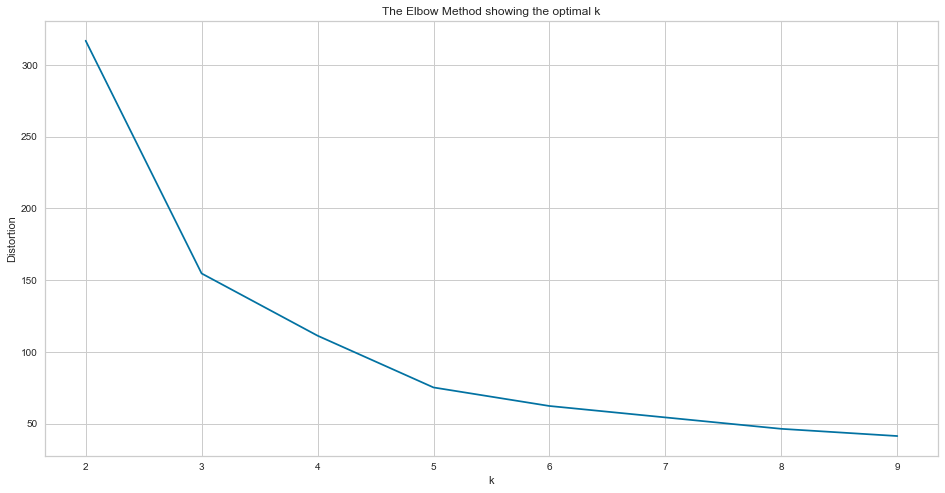

In [51]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Silhouette Score

In [52]:
for i in range(2,10):
    print("Silhouette Score for",i," Clusters is ",score[i-2])
n=score.index(max(score))
numcluster=n+2
print (numcluster," Clusters has the best Silhouette Score")

Silhouette Score for 2  Clusters is  0.3799290732887579
Silhouette Score for 3  Clusters is  0.47285226305952166
Silhouette Score for 4  Clusters is  0.47182955641414204
Silhouette Score for 5  Clusters is  0.45635239723819676
Silhouette Score for 6  Clusters is  0.3989978484610903
Silhouette Score for 7  Clusters is  0.3885178367777608
Silhouette Score for 8  Clusters is  0.3839785440946327
Silhouette Score for 9  Clusters is  0.30848035021087616
3  Clusters has the best Silhouette Score


Visualize the Silhouette Score

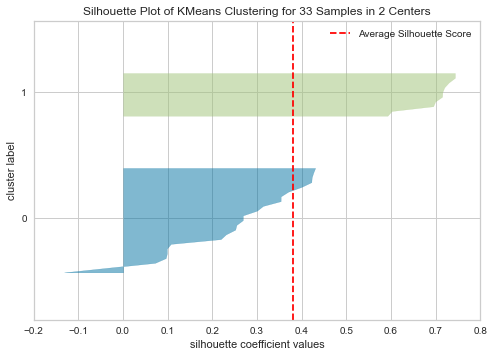

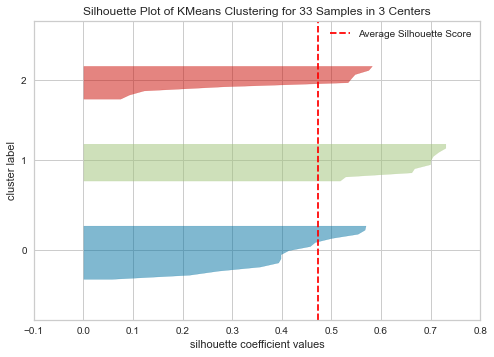

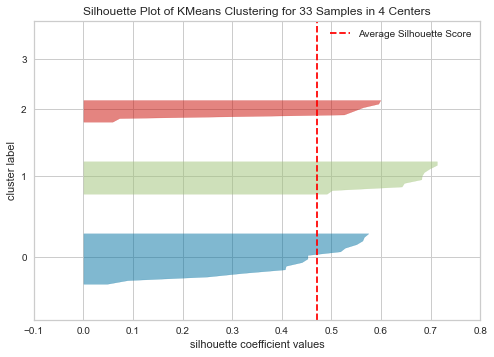

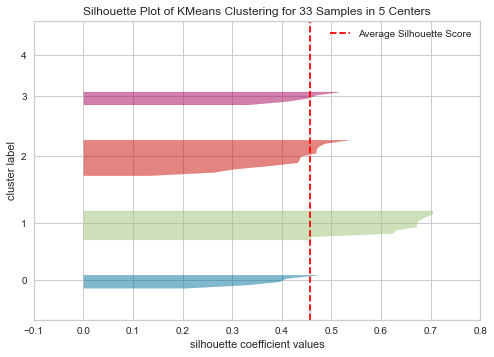

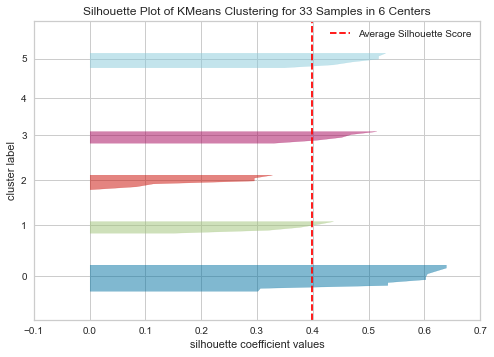

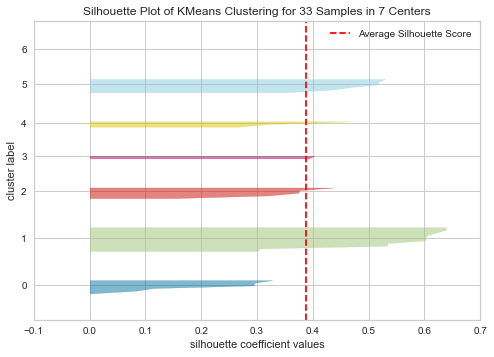

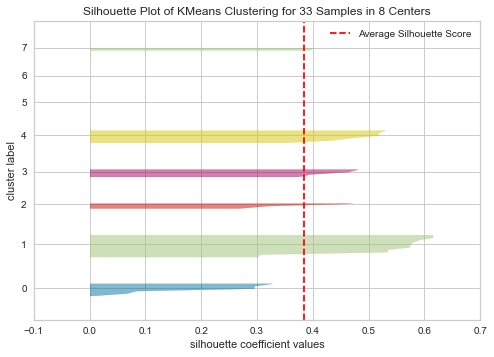

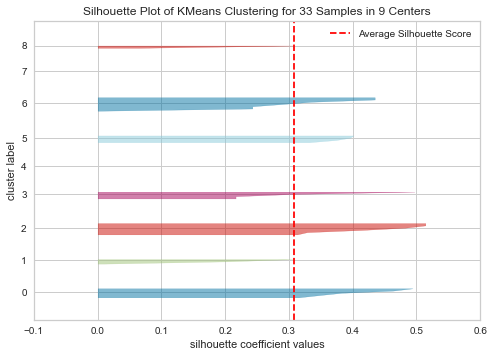

In [53]:
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    visualizer = SilhouetteVisualizer(kmeanModel, colors='yellowbrick')
    visualizer.fit(Manhattan_grouped_clustering)        # Fit the data to the visualizer
    visualizer.show() 

<li>As noticed from the graphs above, 2 Clusters, 3 Clusters, 4 Clusters and 5 Clusters all have Silhouette scores above average Silhouette score which make them candidate for the optimal number of clusters. However, fluctuation in size (thickness) of the silhouette plot representing each cluster also is a deciding point. So, 2 Clusters, 4 Clusters and 5 Clusters have more fluctuation in size as compared to 3 Clusters. For the plot with 3 Clusters, the thickness is more uniform than the plot with 2 Clusters, 4 Clusters and 5 Clusters. Thus, one can select the optimal number of Clusters as 3.</li>

<li>6 Clusters, 7 Clusters, 8 Clusters and 9 Clusters are not considered optimal number of Clusters because of the presence of Clusters with below-average silhouette scores and the fluctuations in the size of the silhouette plots.</li>

In this case the optimal number is 3 so let's run the clustering with 3 clusters 

In [89]:
kclusters = numcluster

Manhattan_grouped_clustering = df_manhattan.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0])

Add the cluster labels to the dataframe

In [90]:
manhattan_df.drop(['Cluster Labels'],axis=1,inplace=True)
manhattan_df.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = manhattan_dataset.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_df.set_index('Neighborhood'), on='Neighborhood')


Some Neighborhoods have 0 number of venues that are related to the user's cuisine of interest...in this case there are neighborhoods that do not have any italian cuisines
<li> These Neighborhoods are shown in the table above as NaN </li>
<li>These Neighborhoods will be added to a new cluster</li> 

In [91]:
nl=list()
for index, row in manhattan_merged.iterrows():
        if (pd.isna(row["Cluster Labels"])):
            manhattan_merged.at[index,'Cluster Labels']=kclusters
            manhattan_merged.at[index,'Nearby_Venue_Primary_Category']=0
            manhattan_merged.at[index,'Number_UserMatched_Venues']=0
            manhattan_merged.at[index,'Avg_Venue_Rating']=0
            manhattan_merged.at[index,'Avg_Venue_Price']=0
            nl.append(row['Neighborhood'])
         

Check types and change to the required data types

In [92]:
manhattan_merged.dtypes

Borough                           object
Neighborhood                      object
Latitude                         float64
Longitude                        float64
Cluster Labels                   float64
Nearby_Venue_Primary_Category     object
Number_UserMatched_Venues        float64
Avg_Venue_Rating                 float64
Avg_Venue_Price                  float64
dtype: object

In [93]:
manhattan_merged['Cluster Labels']=manhattan_merged['Cluster Labels'].astype(int)
manhattan_merged['Number_UserMatched_Venues']=manhattan_merged['Number_UserMatched_Venues'].astype(int)
manhattan_merged['Avg_Venue_Rating']=manhattan_merged['Avg_Venue_Rating'].astype(int)
manhattan_merged['Avg_Venue_Price']=manhattan_merged['Avg_Venue_Price'].astype(int)

Map "Nearby_Venue_Category" column unique entries to numbers so that it becomes easier to analyze 

In [94]:
uniqcolm=manhattan_merged['Nearby_Venue_Primary_Category'].unique()
col_list = uniqcolm.tolist()
col_list

[0,
 'Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport',
 'Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport',
 'Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport',
 'Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service',
 'Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service',
 'Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service',
 'Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport',
 'Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport',
 'Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Shop & Service',
 'Arts & Entertainment,College

In [95]:
for index, row in manhattan_merged.iterrows():
        m=col_list.index(row["Nearby_Venue_Primary_Category"])
        manhattan_merged.at[index,'Nearby_Venue_Primary_Category']=m

Show the finalized dataframe to examine each cluster and to choose the cluster that is best to open up the user's cuisine of interest...In this case Italian

In [96]:
manhattan_merged  

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
0,Manhattan,Marble Hill,40.876551,-73.910660,3,0,0,0,0
1,Manhattan,Chinatown,40.715618,-73.994279,0,1,5,1,2
2,Manhattan,Washington Heights,40.851903,-73.936900,2,2,1,8,2
3,Manhattan,Inwood,40.867684,-73.921210,1,3,1,0,2
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,4,1,0,2
5,Manhattan,Manhattanville,40.816934,-73.957385,1,1,1,0,2
6,Manhattan,Central Harlem,40.815976,-73.943211,3,0,0,0,0
7,Manhattan,East Harlem,40.792249,-73.944182,3,0,0,0,0
8,Manhattan,Upper East Side,40.775639,-73.960508,2,1,1,8,4
9,Manhattan,Yorkville,40.775930,-73.947118,0,5,7,3,2


### Examine each cluster

Visualize the clusters on map

In [97]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [98]:
clusters={}
for i in range (0,4):
    clusters["cluster"+str(i)]=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == i, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Cluster 1

In [99]:
c1=clusters["cluster0"]
c1

,Neighborhood,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
1,Chinatown,1,5,1,2
9,Yorkville,5,7,3,2
14,Clinton,7,7,3,2
15,Midtown,1,12,6,2
16,Murray Hill,3,5,2,2
18,Greenwich Village,1,5,3,2
19,East Village,9,7,1,1
22,Little Italy,1,5,2,2
23,Soho,1,7,2,2
29,Financial District,3,7,4,2


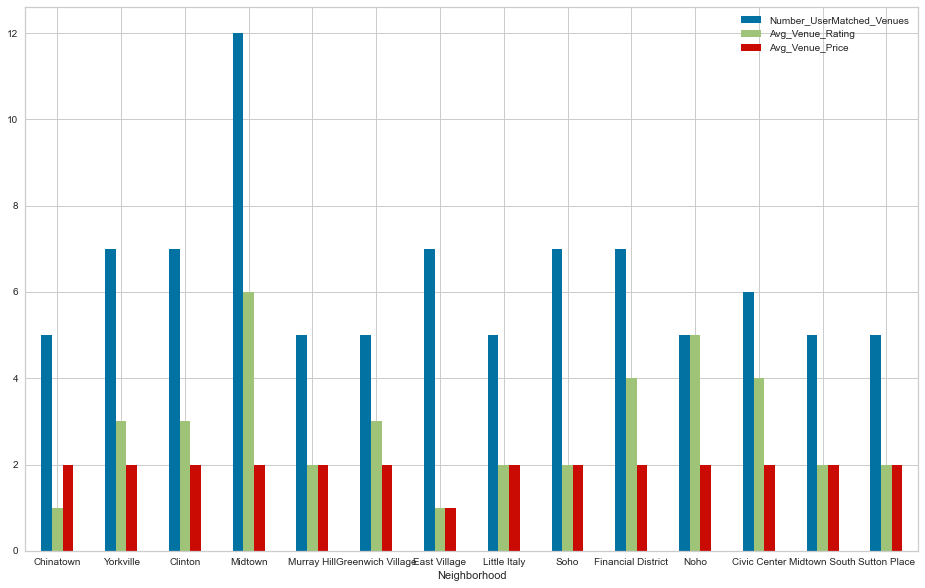

In [100]:
c1.plot.bar(x='Neighborhood', y=['Number_UserMatched_Venues','Avg_Venue_Rating','Avg_Venue_Price'],rot=0,figsize=(16,10))

Cluster 2

In [101]:
c2=clusters["cluster1"]
c2

,Neighborhood,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
3,Inwood,3,1,0,2
4,Hamilton Heights,4,1,0,2
5,Manhattanville,1,1,0,2
10,Lenox Hill,6,2,0,1
17,Chelsea,8,1,0,1
25,Manhattan Valley,2,1,0,1
26,Morningside Heights,10,2,0,2
30,Carnegie Hill,3,1,0,2
38,Flatiron,4,3,0,2
39,Hudson Yards,7,3,0,1


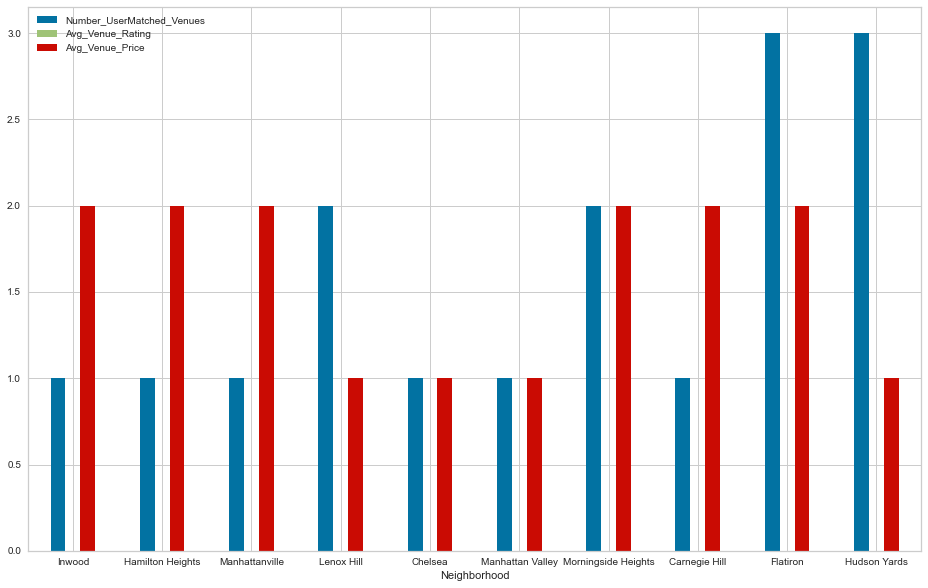

In [102]:
c2.plot.bar(x='Neighborhood', y=['Number_UserMatched_Venues','Avg_Venue_Rating','Avg_Venue_Price'],rot=0,figsize=(16,10))


Cluster 3

In [103]:
c3=clusters["cluster2"]
c3

,Neighborhood,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
2,Washington Heights,2,1,8,2
8,Upper East Side,1,1,8,4
12,Upper West Side,3,4,5,2
20,Lower East Side,9,2,4,2
24,West Village,1,4,6,2
27,Gramercy,3,2,8,1
28,Battery Park City,3,1,7,2
35,Turtle Bay,7,5,6,3
36,Tudor City,11,1,7,4


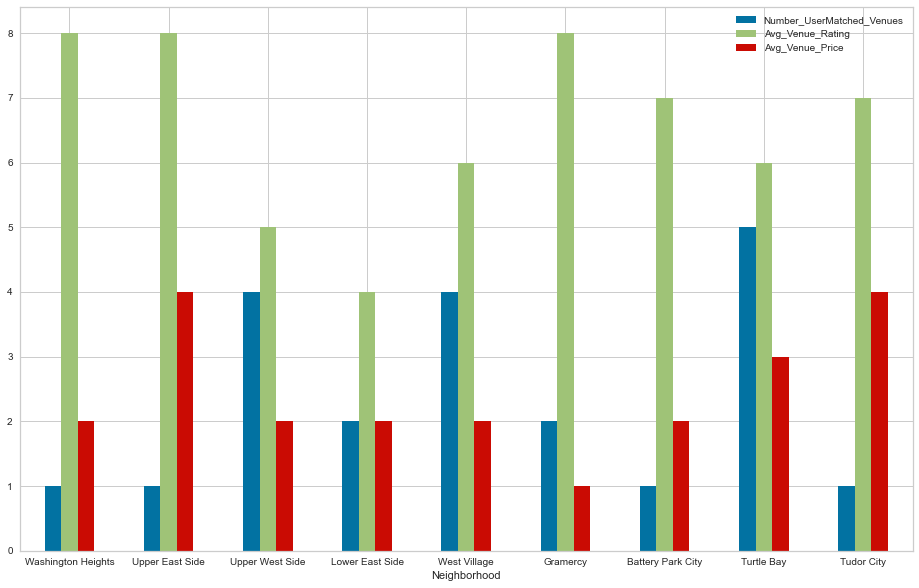

In [104]:
c3.plot.bar(x='Neighborhood', y=['Number_UserMatched_Venues','Avg_Venue_Rating','Avg_Venue_Price'],rot=0,figsize=(16,10))

Cluster 4

In [105]:
c4=clusters["cluster3"]
c4

,Neighborhood,Nearby_Venue_Primary_Category,Number_UserMatched_Venues,Avg_Venue_Rating,Avg_Venue_Price
0,Marble Hill,0,0,0,0
6,Central Harlem,0,0,0,0
7,East Harlem,0,0,0,0
11,Roosevelt Island,0,0,0,0
13,Lincoln Square,0,0,0,0
21,Tribeca,0,0,0,0
37,Stuyvesant Town,0,0,0,0


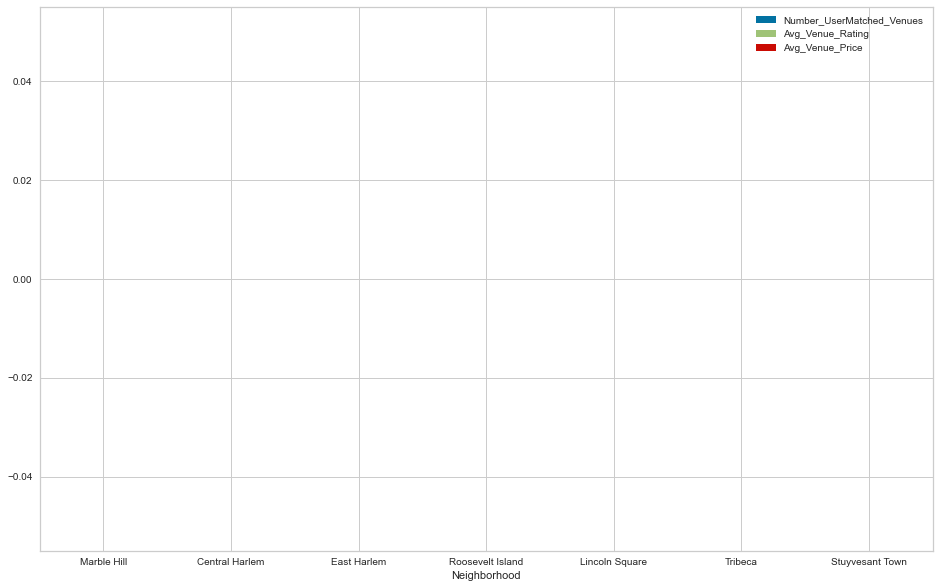

In [106]:
c4.plot.bar(x='Neighborhood', y=['Number_UserMatched_Venues','Avg_Venue_Rating','Avg_Venue_Price'],rot=0,figsize=(16,10))

As noticed from the map, cluster tables and charts, Neighborhoods [Marble Hill, Central Harlem, East Harlem, Roosevelt Island, Lincoln Square, Tribeca, Stuyvesant Town] have 0 number of Italian cuisines. These Neighborhoods were grouped into a new cluster which is Cluster 4


Clusters 1-3 are identified according to the number venues matched to the user's entry in the neighborhood, their average rating, average price and their surrounding popular spots.

However, it is noticed that the popular spots in each neighborhoods are kind of similar in each cluster.

As seen in charts above:
<li> Cluster 1 grouped Neighborhoods that have high number of italian cuisine with Moderate price range and average rating </li>
<li> Cluster 2 grouped Neighborhoods that have low number of italian cuisine with Moderate price and no rating </li>
<li>Cluster 3 grouped Neighborhoods that have low number of italian cuisine with above Moderate price and high rating </li>
<li>Cluster 4 grouped Neighborhoods that have 0 number of italian cuisines</li>

The choice of which cluster to open up the italian cuisine depends on the user's target for the italian restaurant.
<li> So if the user is thinking of opening up a luxurious italian restaurant then the price range will be above Moderate and so cluster 2 or 4. </li>


However, there should be more information on the neighborhoods such as demographics and to know people's interests and tendancies. There will be more insight and in this way it will be known, for example, if there is demand for italian cusisine in Cluster 4 or not. 
